<a href="https://colab.research.google.com/github/rohithmn01/prom_forecast/blob/main/Auto_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import copy 
import pandas as pd
URL = "http://34.67.240.237:30000/api/v1/query?query=node_memory_MemFree_bytes{instance=\"10.56.0.2:9100\",job=\"node-exporter\"}[1d]" 
r = requests.get(url = URL) 

data = r.json()

data_dict={}
metric_list = []

for i in data['data']['result']:
    counter=0
    for j in i['values']:
        data_dict = copy.deepcopy(i['metric'])
        data_dict['time'] = j[0]
        data_dict['value'] = j[1]
        metric_list.append(data_dict)        
  
df_metric = pd.DataFrame(metric_list)

df1 = df_metric[['time', 'value']]
df1['time'] = pd.to_datetime(df1['time'],unit='s')
df1 = df1.set_index('time')
df1["value"] = df1.values.astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
df1

,value
time,
2021-08-29 10:33:42.460000038,2.615947e+09
2021-08-29 10:33:47.460000038,2.616762e+09
2021-08-29 10:33:52.460000038,2.618012e+09
2021-08-29 10:33:57.460000038,2.616238e+09
2021-08-29 10:34:02.460000038,2.617721e+09
...,...
2021-08-30 10:33:17.460000038,2.587505e+09
2021-08-30 10:33:22.460000038,2.587795e+09
2021-08-30 10:33:27.460000038,2.589295e+09


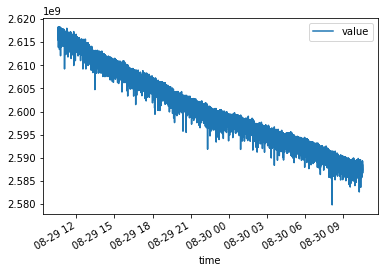

In [3]:
df1.plot()

In [4]:
df1.describe()

,value
count,1.728000e+04
mean,2.600750e+09
std,8.336781e+06
min,2.579837e+09
25%,2.593878e+09
50%,2.599612e+09
75%,2.607694e+09
max,2.618311e+09


In [5]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
adfuller_test(df1['value'])

ADF Test Statistic : -1.1614259381375054
p-value : 0.6899654138355307
#Lags Used : 43
Number of Observations Used : 17236
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [7]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

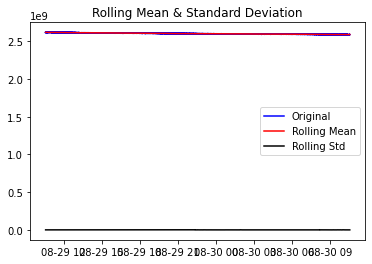

Results of Dickey-Fuller Test:
Test Statistic                    -1.161426
p-value                            0.689965
#Lags Used                        43.000000
Number of Observations Used    17236.000000
Critical Value (1%)               -3.430729
Critical Value (5%)               -2.861708
Critical Value (10%)              -2.566859
dtype: float64


In [8]:
test_stationarity(df1['value'])

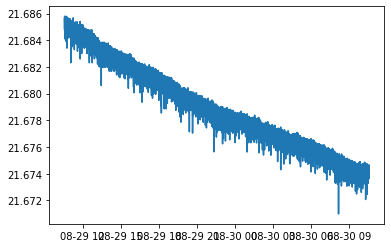

In [9]:
#make the time series stationary
#MAKING TS STATIONARY
import numpy as np
ts_log = np.log(df1['value'])
plt.plot(ts_log)

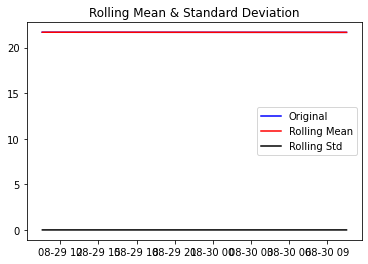

Results of Dickey-Fuller Test:
Test Statistic                    -1.148850
p-value                            0.695204
#Lags Used                        43.000000
Number of Observations Used    17236.000000
Critical Value (1%)               -3.430729
Critical Value (5%)               -2.861708
Critical Value (10%)              -2.566859
dtype: float64


In [10]:
test_stationarity(ts_log)


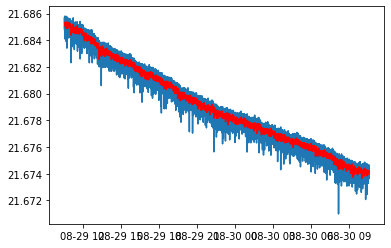

In [11]:
#Smoothing
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(5)

time
2021-08-29 10:33:42.460000038   NaN
2021-08-29 10:33:47.460000038   NaN
2021-08-29 10:33:52.460000038   NaN
2021-08-29 10:33:57.460000038   NaN
2021-08-29 10:34:02.460000038   NaN
Name: value, dtype: float64

In [13]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head(5)

time
2021-08-29 10:34:37.460000038    0.000381
2021-08-29 10:34:42.460000038   -0.000421
2021-08-29 10:34:47.460000038    0.000145
2021-08-29 10:34:52.460000038   -0.000174
2021-08-29 10:34:57.460000038   -0.001114
Name: value, dtype: float64

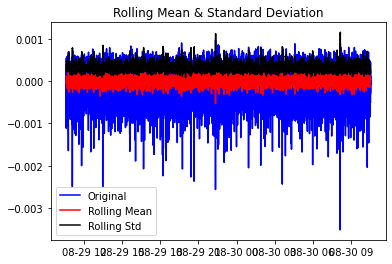

Results of Dickey-Fuller Test:
Test Statistic                   -29.327637
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    17224.000000
Critical Value (1%)               -3.430730
Critical Value (5%)               -2.861708
Critical Value (10%)              -2.566859
dtype: float64


In [14]:
#TEST STATIONARITY AGAIN
test_stationarity(ts_log_moving_avg_diff)

In [17]:
#ts_log.values
ts_values=ts_log.values

In [18]:
X = ts_values
size = int(len(X) * 0.667)
train, test = X[0:size], X[size:len(X)]

In [20]:
### AUTO ARIMA
!pip install pmdarima


     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████████████████████████| 9.5 MB 28.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [21]:
from pmdarima.arima import auto_arima


ImportError: ignored